In [3]:
# K-Means Algorithm K-평균 알고리즘

import numpy as np

num_points = 2000 # 데이터 2000개를 만든다
vectors_set = []

for i in range(num_points):
    if np.random.random() > 0.5: 
        # 0.5보다 큰 것 (대략 절반)
        vectors_set.append([np.random.normal(0.0, 0.9), np.random.normal(0.0, 0.9)])
        # x가 평균 0.0, 표준편차 0.9인 정규분포를 따름
        # y가 평균 0.0, 표준편자 0.9인 정규분포를 따름
        
    else: # 0.5보다 작은것 (대략 절반)
        vectors_set.append([np.random.normal(3.0, 0.5), np.random.normal(1.0, 0.5)])
        # x가 평균 3.0, 표준편차 0.5인 정규분포를 따름
        # y가 평균 1.0, 표준편차 0.5인 정규분포를 따름

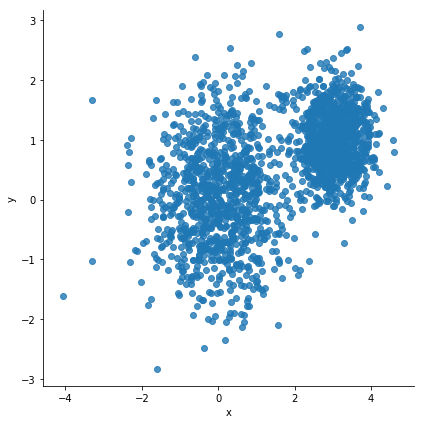

In [4]:
# 난수 데이터 시각화

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

df = pd.DataFrame({"x" : [v[0] for v in vectors_set], "y" : [v[1] for v in vectors_set]})
sns.lmplot("x", "y", data=df, fit_reg=False, size=6)
plt.show()

In [8]:
import tensorflow as tf

vectors = tf.constant(vectors_set)

k = 4
centroids = tf.Variable(tf.slice(tf.random_shuffle(vectors), [0,0], [k,-1]))
# 중심 설정

vectors.get_shape() # 텐서의 구조 파악하기

TensorShape([Dimension(2000), Dimension(2)])

###### vectors는 D0 차원은 크기가 2000개이고, D1 차원은 크기가 2이다. (각 점의 x, y좌표)
###### 2차원 텐서

In [9]:
centroids.get_shape() # 중심 얘네는 구조 어떻게 되어 있니?

TensorShape([Dimension(4), Dimension(2)])

###### centroids는 D0 차원의 크기가 4이고, D1 차원은 vectors와 동일하게 크기가 2이다 (각 점의 x, y좌표)
###### 2차원 텐서
###### 애초에 k를 4로 잡았으니 이 값이 나오는건 당연하지

In [16]:
expanded_vectors = tf.expand_dims(vectors, 0)
expanded_centroids = tf.expand_dims(centroids, 1)

# tf.expand_dims 함수를 사용하여 두 텐서에 차원을 추가한다
# 두 텐서를 2차원에서 3차원으로 만들어서 뺄샘을 할 수 있도록 크기를 맞추기 위함

In [18]:
expanded_vectors.get_shape()

TensorShape([Dimension(1), Dimension(2000), Dimension(2)])

##### vectors에는 첫번째 차원 D0을 추가했다는 것을 알 수 있음 Dimension(1)

In [20]:
expanded_centroids.get_shape()

TensorShape([Dimension(4), Dimension(1), Dimension(2)])

##### centroid에는 두번째 차원 D1을 추가했다는 것을 알 수 있음 Dimension(1)

#### 크기가 1인 차원은 텐서 연산시 다른 텐서의 해당 차원 크기에 맞게 계산을 반복하므로 마치 차원이 늘어난 것 같은 효과를 가짐
#### 참고 : Numpy 문서 - http://bit.ly/2aMAehC

In [53]:
# 유클리드 제곱 거리를 사용한 할당단계 1단계의 알고리즘

distances = tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, expanded_centroids)), 2)
assignments = tf.argmin(distances, 0)

In [54]:
# 위 유클리드 제곱 거리 저거를 풀어서 쓰면

# 구분을 위해 여기서는 distances2와 assignments2

diff = tf.subtract(expanded_vectors, expanded_centroids)
# expanded_vectors와 expanded_centroids의 차이를 구해라 

sqr = tf.square(diff)
# 제곱해라

distances2 = tf.reduce_sum(sqr, 2) # D2를 합친다 (차원감소)
# 즉, Dimension(2)를 합친다 (차원감소)

# tf.reduce_sum : 지정된 차원을 따라 원소들을 더해라
# 차원을 감소시키는 수학 연산

assignments2 = tf.argmin(distances2, 0) # D0을 합친다 (차원감소)
# 즉, Dimension(4)를 합친다 (차원 감소)

# 그리고 최솟값을 구해내라 tf.argmin

In [55]:
diff.get_shape()

TensorShape([Dimension(4), Dimension(2000), Dimension(2)])

In [56]:
sqr.get_shape()

TensorShape([Dimension(4), Dimension(2000), Dimension(2)])

In [57]:
distances2.get_shape()

TensorShape([Dimension(4), Dimension(2000)])

In [58]:
assignments2.get_shape()

TensorShape([Dimension(2000)])

In [60]:
# 새로운 중심 계산하기
# 매 반복마다 새롭게 그룹화를 하면서 각 그룹에 해당하는 새로운 중심을 다시 계산함

means = tf.concat([tf.reduce_mean(tf.gather(vectors, 
                                           tf.reshape(tf.where(tf.equal(assignments, c)), [1, -1])),
                                 reduction_indices = [1]) for c in range(k)], 0)

# tf.reduce_mean : 지정된 차원을 따라 평균을 계산합니다

In [62]:
update_centroids = tf.assign(centroids, means)

# means 텐서의 값을 centroids에 할당함
# run() 메소드가 실행될 때 업데이트된 중심 값이 다음번 루프에서 사용되기 위해서

In [64]:
init_op = tf.global_variables_initializer()

# 데이터 그래프를 실행하기 전에 모든 변수를 초기화함

In [65]:
# 데이터 그래프 실행하기

sess = tf.Session()
sess.run(init_op)

for step in range(100): # 100번의 반복
    _, centroid_values, assignment_values = sess.run([update_centroids, centroids, assignments])

    # 앞에 _, 가 있는 이유는, update_centroids 연산은 리턴값이 없기 때문에 _ 밑줄을 사용해 결과를 버리게 함
    
# 이 코드를 통해 매 반복마다 중심은 업데이트되고 각 점은 새롭게 군집에 할당됨

In [66]:
print(centroid_values)

[[ 2.4251072   0.70476365]
 [-0.05423592  0.7353176 ]
 [ 3.2795677   1.1411726 ]
 [-0.10109752 -0.6990668 ]]
